# SVM IY010_simulation_7_mu_ratio_analysis:  

In [1]:
from __future__ import annotations
import numpy as np
import pandas as pd
import glob
from pathlib import Path
from typing import Dict, Optional
import sys
import os
import re
from collections import defaultdict
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Add src directory to Python path
sys.path.append(str(Path.cwd().parent.parent.parent / "src"))

# Import custom modules
from classifiers.svm_classifier import svm_classifier, grid_search_svm
from models.TF_transformer import TFTransformer, ModelCfg
from utils.data_processing import add_binary_labels, add_nearest_neighbour_labels
from utils.standardise_time_series import standardise_time_series
from utils.shuffle_time_series import shuffle_time_series

# Import sklearn modules for SVM
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

%load_ext autoreload
%autoreload 2

In [2]:
##### Set up directory paths for data loading ######
BASE_DIR = Path.cwd().parent
OUT_DIR = BASE_DIR
SYNTHETIC_DIR = BASE_DIR / "data_7_mu_ratios" 
RESULTS_CSV = "IY010_simulation_parameters_7_mu_ratios.csv"
results_csv_path = BASE_DIR / RESULTS_CSV
results = pd.read_csv(results_csv_path)
results = results[results["success"]].dropna(
    subset=["mu_observed", "cv_observed", "t_ac_observed"]
)

# SVM Parameters
SVM_C = 1.0           # Regularization parameter
SVM_GAMMA = 'scale'   # Kernel coefficient 
SVM_KERNEL = 'rbf'    # Kernel type
TEST_SPLIT = 0.2
RANDOM_STATE = 42

print(f"Total trajectories: {len(results)}")

# Get unique mu_ratio values
unique_mu_ratios = sorted(results['ratio'].unique())
print(f"Unique mu_ratio values: {unique_mu_ratios}")

Total trajectories: 264
Unique mu_ratio values: [1.0, 1.1, 1.2000000000000002, 1.3000000000000005, 1.4000000000000004, 1.5000000000000004, 1.6000000000000003, 1.7000000000000006, 1.8000000000000007, 1.9000000000000008, 2.000000000000001]


Each dataset has 1 mu_target value, but different cv_target and t_ac_target values (Sobol sampled), the base mu_target is 1000, and is scaled by the mu_ratio from 1.0 to 2.0 with a 0.1 increment.

We classify the trajectories based on their mu_target values, using the base mu_target as the reference point, labelled 0, and every other mu_target as the target point, labelled 1.

In [3]:
# =========================================================
# mu_ratio Classification Analysis
# Base vs Target mu_ratio Binary Classification
# =========================================================
print(f"\n{'='*80}")
print(f"🎯 mu_ratio Classification Analysis")
print(f"{'='*80}")

# Define base mu_ratio and target tolerance for matching cv and t_ac
BASE_MU_RATIO = 1.0
CV_TOLERANCE = 0.05  # tolerance for matching cv_target, using this because we used Sobol sequence sampling for the data generation.
TAC_TOLERANCE = 2.0  # tolerance for matching t_ac_target

# Get base dataset
base_results = results[results['ratio'] == BASE_MU_RATIO].copy()
print(f"Base dataset (mu_ratio = {BASE_MU_RATIO}): {len(base_results)} trajectories")

# Store results for plotting
classification_mu_ratios = []
classification_accuracies = []
sample_counts = []

# Get all mu_ratios except base
target_mu_ratios = [r for r in unique_mu_ratios if r != BASE_MU_RATIO]

for target_mu_ratio in target_mu_ratios:
    print(f"\n🔍 Analyzing mu_ratio {target_mu_ratio:.2f} vs base {BASE_MU_RATIO:.2f}")
    
    target_results = results[results['ratio'] == target_mu_ratio].copy()
    
    # Find matching cv and t_ac pairs between base and target
    matched_pairs = []
    
    for _, base_row in base_results.iterrows():
        base_cv = base_row['cv_target']
        base_tac = base_row['t_ac_target']
        
        # Find target trajectories with similar cv and t_ac
        cv_mask = np.abs(target_results['cv_target'] - base_cv) <= CV_TOLERANCE
        tac_mask = np.abs(target_results['t_ac_target'] - base_tac) <= TAC_TOLERANCE
        matching_targets = target_results[cv_mask & tac_mask]
        
        if len(matching_targets) > 0:
            # Take the closest match
            distances = (np.abs(matching_targets['cv_target'] - base_cv) + 
                        np.abs(matching_targets['t_ac_target'] - base_tac))
            best_match_idx = distances.idxmin()
            target_row = matching_targets.loc[best_match_idx]
            
            matched_pairs.append((base_row, target_row))
    
    print(f"Found {len(matched_pairs)} matched trajectory pairs")
    
    if len(matched_pairs) < 5:  # Need minimum samples for classification
        print(f"⚠️ Insufficient matched pairs for mu_ratio {target_mu_ratio}")
        continue
    
    # Collect data for binary classification
    data_frames = []
    labels = []
    
    for base_row, target_row in matched_pairs:
        # print the cv_target and the t_ac_target for the matched pairs
        # print(f"Base cv_target: {base_row['cv_target']:.2f}, Base t_ac_target: {base_row['t_ac_target']:.2f}")
        # print(f"Target cv_target: {target_row['cv_target']:.2f}, Target t_ac_target: {target_row['t_ac_target']:.2f}")
        
        # Load base trajectory (label = 0)
        base_file = SYNTHETIC_DIR / base_row["trajectory_filename"]
        if base_file.exists():
            base_data = pd.read_csv(base_file)
            data_frames.append(base_data)
            labels.append(0)  # base label
        
        # Load target trajectory (label = 1)
        target_file = SYNTHETIC_DIR / target_row["trajectory_filename"]
        if target_file.exists():
            target_data = pd.read_csv(target_file)
            data_frames.append(target_data)
            labels.append(1)  # target label
    
    if len(data_frames) == 0:
        print(f"⚠️ No valid data files found for mu_ratio {target_mu_ratio}")
        continue
    
    # Standardize time series
    labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")
    
    # Check class balance
    class_counts = np.bincount(labelled_data['label'].values)
    print(f"Class distribution: Base (0): {class_counts[0]}, Target (1): {class_counts[1]}")
    
    if len(class_counts) < 2 or np.min(class_counts) < 2:
        print(f"⚠️ Insufficient samples per class for mu_ratio {target_mu_ratio}")
        continue
    
    # Prepare features and labels
    df = labelled_data.copy()
    y = df["label"].values
    X = df.drop(columns=["label"]).values
    
    print(f"Feature matrix shape: {X.shape}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=TEST_SPLIT, 
        random_state=RANDOM_STATE,
        stratify=y
    )
    
    # Train SVM for binary classification
    svm_accuracy = svm_classifier(
        X_train, X_test, y_train, y_test,
        svm_C=SVM_C,
        svm_gamma=SVM_GAMMA, 
        svm_kernel=SVM_KERNEL,
        print_classification_report=False,
        print_confusion_matrix=False,
    )
    
    # Store results
    classification_mu_ratios.append(target_mu_ratio)
    classification_accuracies.append(svm_accuracy)
    sample_counts.append(len(matched_pairs))
    
    print(f"✅ mu_ratio {target_mu_ratio:.2f}: Accuracy = {svm_accuracy:.3f}, Samples = {len(matched_pairs)} pairs")




🎯 mu_ratio Classification Analysis
Base dataset (mu_ratio = 1.0): 24 trajectories

🔍 Analyzing mu_ratio 1.10 vs base 1.00
Found 24 matched trajectory pairs
Class distribution: Base (0): 1200, Target (1): 1200
Feature matrix shape: (2400, 144)
=== SVM (RBF Kernel) Classification Accuracy: 0.48 ===
✅ mu_ratio 1.10: Accuracy = 0.479, Samples = 24 pairs

🔍 Analyzing mu_ratio 1.20 vs base 1.00
Found 24 matched trajectory pairs
Class distribution: Base (0): 1200, Target (1): 1200
Feature matrix shape: (2400, 144)
=== SVM (RBF Kernel) Classification Accuracy: 0.52 ===
✅ mu_ratio 1.20: Accuracy = 0.523, Samples = 24 pairs

🔍 Analyzing mu_ratio 1.30 vs base 1.00
Found 24 matched trajectory pairs
Class distribution: Base (0): 1200, Target (1): 1200
Feature matrix shape: (2400, 144)
=== SVM (RBF Kernel) Classification Accuracy: 0.54 ===
✅ mu_ratio 1.30: Accuracy = 0.544, Samples = 24 pairs

🔍 Analyzing mu_ratio 1.40 vs base 1.00
Found 24 matched trajectory pairs
Class distribution: Base (0): 120


📊 Creating mu_ratio classification plot...


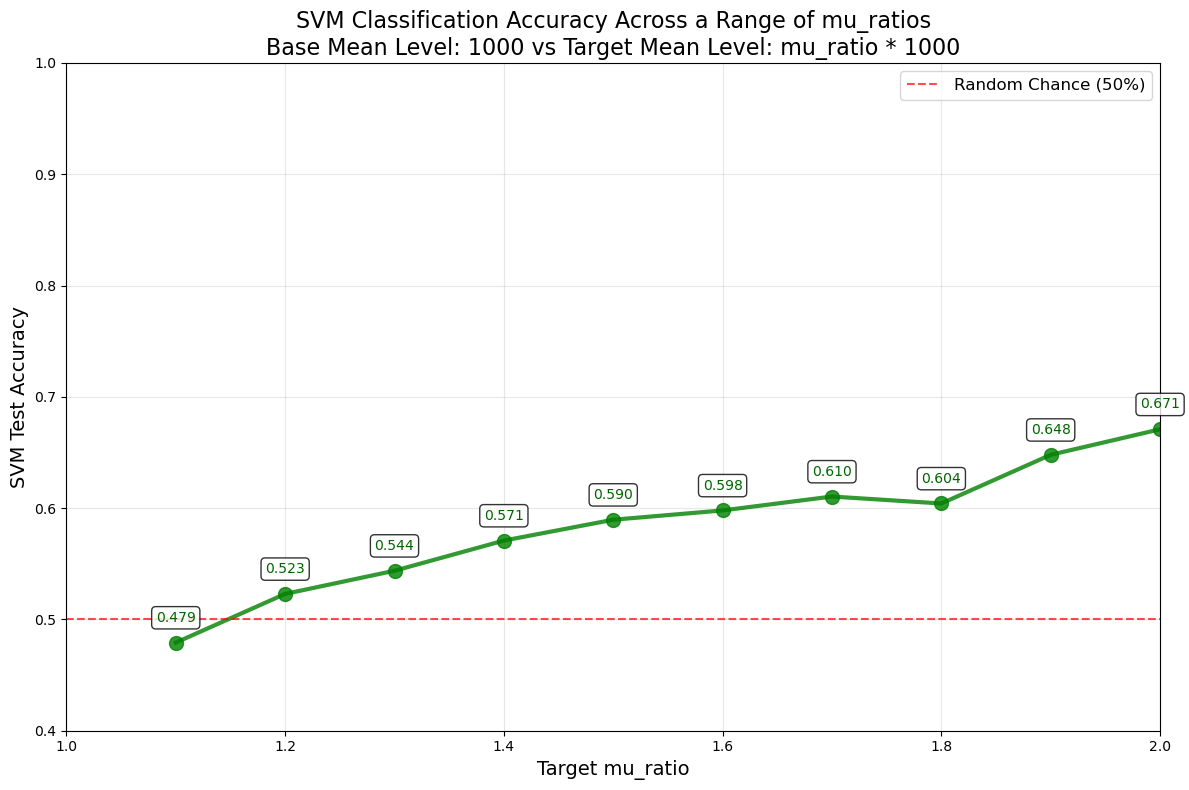


📈 mu_ratio Classification Summary:
Base mu_ratio: 1.0
Target_ratio Accuracy   Samples  Above_Random
--------------------------------------------------
1.1          0.479      24       No          
1.2          0.523      24       Yes         
1.3          0.544      24       Yes         
1.4          0.571      24       Yes         
1.5          0.590      24       Yes         
1.6          0.598      24       Yes         
1.7          0.610      24       Yes         
1.8          0.604      24       Yes         
1.9          0.648      24       Yes         
2.0          0.671      24       Yes         

Overall Statistics:
Mean Accuracy: 0.584
Std Accuracy: 0.054
Max Accuracy: 0.671 (at mu_ratio 2.0)
Min Accuracy: 0.479 (at mu_ratio 1.1)
Ratios distinguishable from base (>60% accuracy): 4/10


In [4]:
# =========================================================
# Create Classification Plot
# =========================================================
print(f"\n📊 Creating mu_ratio classification plot...")

plt.figure(figsize=(12, 8))

# Plot classification accuracies
plt.plot(classification_mu_ratios, classification_accuracies, 'o-', 
         linewidth=3, markersize=10, color='green', alpha=0.8)

# Add horizontal line at 50% (random chance)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, 
            label='Random Chance (50%)')

# Customize plot
plt.xlabel('Target mu_ratio', fontsize=14)
plt.ylabel('SVM Test Accuracy', fontsize=14)
plt.title(f'SVM Classification Accuracy Across a Range of mu_ratios\n'
          f'Base Mean Level: 1000 vs Target Mean Level: mu_ratio * 1000', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Set axis limits for better visualization
plt.ylim(0.4, 1.0)
plt.xlim(1.0, 2.0)

# Add value annotations
for i, (mu_r, acc, samples) in enumerate(zip(classification_mu_ratios, classification_accuracies, sample_counts)):
    plt.annotate(f'{acc:.3f}', (mu_r, acc), # sample size for each point on the plot: {samples}
                textcoords="offset points", xytext=(0,15), ha='center', 
                fontsize=10, color='darkgreen', 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.show()

# =========================================================
# Classification Summary
# =========================================================
print(f"\n📈 mu_ratio Classification Summary:")
print(f"Base mu_ratio: {BASE_MU_RATIO}")
print(f"{'Target_ratio':<12} {'Accuracy':<10} {'Samples':<8} {'Above_Random':<12}")
print(f"{'-'*50}")
for mu_r, acc, samples in zip(classification_mu_ratios, classification_accuracies, sample_counts):
    above_random = "Yes" if acc > 0.5 else "No"
    print(f"{mu_r:<12.1f} {acc:<10.3f} {samples:<8d} {above_random:<12}")

if len(classification_accuracies) > 0:
    print(f"\nOverall Statistics:")
    print(f"Mean Accuracy: {np.mean(classification_accuracies):.3f}")
    print(f"Std Accuracy: {np.std(classification_accuracies):.3f}")
    print(f"Max Accuracy: {np.max(classification_accuracies):.3f} (at mu_ratio {classification_mu_ratios[np.argmax(classification_accuracies)]:.1f})")
    print(f"Min Accuracy: {np.min(classification_accuracies):.3f} (at mu_ratio {classification_mu_ratios[np.argmin(classification_accuracies)]:.1f})")
    
    # Count how many ratios are distinguishable from base
    distinguishable = np.sum(np.array(classification_accuracies) > 0.6)  # 60% threshold
    print(f"Ratios distinguishable from base (>60% accuracy): {distinguishable}/{len(classification_accuracies)}")

The below is optional and redundant, the test accuracy is expected to be the same: we are labelling based on target cv value.


🔬 Analyzing ratio = 1.0
Trajectories for mu_ratio 1.0: 24
Class distribution: [600 600]
Feature matrix shape: (1200, 144)

📈 Original Time Series - mu_ratio = 1.0
=== SVM (RBF Kernel) Classification Accuracy: 0.77 ===

🔀 Shuffled Time Series - mu_ratio = 1.0
=== SVM (RBF Kernel) Classification Accuracy: 0.71 ===
✅ mu_ratio 1.0: Original=0.771, Shuffled=0.713

🔬 Analyzing ratio = 1.1
Trajectories for mu_ratio 1.1: 24
Class distribution: [600 600]
Feature matrix shape: (1200, 144)

📈 Original Time Series - mu_ratio = 1.1
=== SVM (RBF Kernel) Classification Accuracy: 0.72 ===

🔀 Shuffled Time Series - mu_ratio = 1.1
=== SVM (RBF Kernel) Classification Accuracy: 0.70 ===
✅ mu_ratio 1.1: Original=0.725, Shuffled=0.700

🔬 Analyzing ratio = 1.2000000000000002
Trajectories for mu_ratio 1.2000000000000002: 24
Class distribution: [600 600]
Feature matrix shape: (1200, 144)

📈 Original Time Series - mu_ratio = 1.2000000000000002
=== SVM (RBF Kernel) Classification Accuracy: 0.76 ===

🔀 Shuffled 

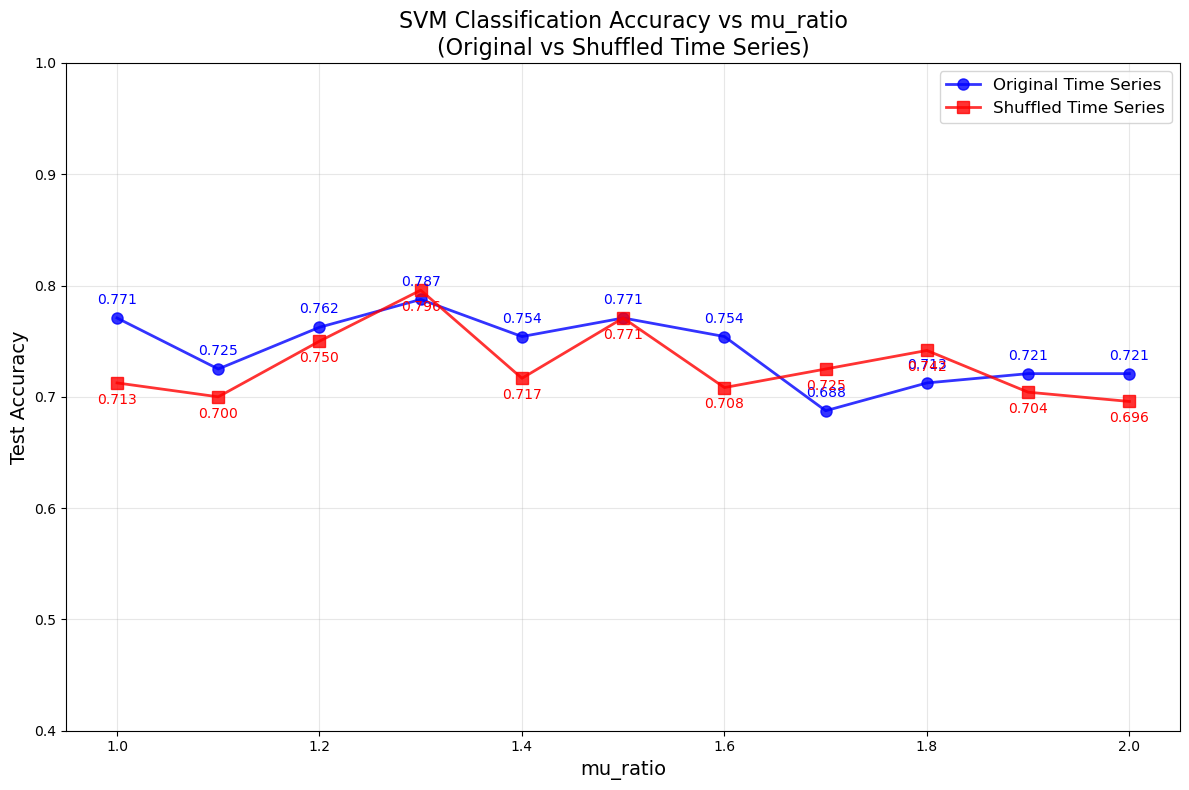


📈 Summary Statistics:
mu_ratio   Original   Shuffled   Difference  
--------------------------------------------------
1.000      0.771      0.713      0.058       
1.100      0.725      0.700      0.025       
1.200      0.762      0.750      0.012       
1.300      0.787      0.796      -0.008      
1.400      0.754      0.717      0.037       
1.500      0.771      0.771      0.000       
1.600      0.754      0.708      0.046       
1.700      0.688      0.725      -0.037      
1.800      0.713      0.742      -0.029      
1.900      0.721      0.704      0.017       
2.000      0.721      0.696      0.025       

Overall Statistics:
Original - Mean: 0.742, Std: 0.029
Shuffled - Mean: 0.729, Std: 0.031
Mean Difference (Original - Shuffled): 0.013


In [5]:
# Store results for plotting
mu_ratios = []
original_accuracies = []
shuffled_accuracies = []

# add labels based on the target cv
label_column = 'cv_target' 
labelled_results = add_binary_labels(results, label_column)

# =========================================================
# Analysis for Each mu_ratio
# =========================================================
for mu_ratio in unique_mu_ratios:
    print(f"\n{'='*60}")
    print(f"🔬 Analyzing ratio = {mu_ratio}")
    print(f"{'='*60}")
    
    # Filter data for current mu_ratio
    current_results = results[results['ratio'] == mu_ratio].copy()
    current_labelled = labelled_results[labelled_results['ratio'] == mu_ratio].copy()

    print(f"Trajectories for mu_ratio {mu_ratio}: {len(current_results)}")
    
    if len(current_results) < 10:  # Skip if too few samples
        print(f"⚠️ Skipping mu_ratio {mu_ratio} - insufficient samples")
        continue
    
    # Collect DataFrames and labels for current mu_ratio
    data_frames = []
    labels = []
    
    for i, row in current_results.iterrows():
        trajectory_filename = row["trajectory_filename"]
        DATA_CSV = SYNTHETIC_DIR / trajectory_filename
        
        if not DATA_CSV.exists():
            continue
            
        data = pd.read_csv(DATA_CSV)
        data_frames.append(data)
        
        # Get the corresponding label
        label_value = current_labelled[current_labelled['trajectory_filename'] == trajectory_filename]['label'].iloc[0]
        labels.append(label_value)
    
    if len(data_frames) == 0:
        print(f"⚠️ No valid data files found for mu_ratio {mu_ratio}")
        continue
    
    # Standardize time series
    labelled_data = standardise_time_series(data_frames, labels=labels, prefix="t_")
    
    # Check class balance
    class_counts = np.bincount(labelled_data['label'].values)
    print(f"Class distribution: {class_counts}")
    
    if len(class_counts) < 2 or np.min(class_counts) < 2:
        print(f"⚠️ Skipping mu_ratio {mu_ratio} - insufficient samples per class")
        continue
    
    # Prepare features and labels
    df = labelled_data.copy()
    y = df["label"].values
    X = df.drop(columns=["label"]).values
    
    print(f"Feature matrix shape: {X.shape}")
    
    # =========================================================
    # Original Time Series Analysis
    # =========================================================
    print(f"\n📈 Original Time Series - mu_ratio = {mu_ratio}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=TEST_SPLIT, 
        random_state=RANDOM_STATE,
        stratify=y
    )
    
    # Train SVM
    svm_accuracy = svm_classifier(
        X_train, X_test, y_train, y_test,
        svm_C=SVM_C,
        svm_gamma=SVM_GAMMA, 
        svm_kernel=SVM_KERNEL,
        print_classification_report=False,
        print_confusion_matrix=False,
    )
    
    # =========================================================
    # Shuffled Time Series Analysis
    # =========================================================
    print(f"\n🔀 Shuffled Time Series - mu_ratio = {mu_ratio}")
    
    # Create shuffled data
    df_shuffled = shuffle_time_series(
        df, 
        preserve_columns=['label'], 
        random_state=RANDOM_STATE
    )
    
    # Extract features and labels from shuffled data
    y_shuffled = df_shuffled["label"].values
    X_shuffled = df_shuffled.drop(columns=["label"]).values
    
    # Split the shuffled data
    X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled = train_test_split(
        X_shuffled, 
        y_shuffled, 
        test_size=TEST_SPLIT,
        random_state=RANDOM_STATE,
        stratify=y_shuffled
    )
    
    # Train SVM on shuffled data
    svm_accuracy_shuffled = svm_classifier(
        X_train_shuffled, X_test_shuffled, y_train_shuffled, y_test_shuffled,
        svm_C=SVM_C,
        svm_gamma=SVM_GAMMA, 
        svm_kernel=SVM_KERNEL,
        print_classification_report=False,
        print_confusion_matrix=False,
    )
    
    # Store results
    mu_ratios.append(mu_ratio)
    original_accuracies.append(svm_accuracy)
    shuffled_accuracies.append(svm_accuracy_shuffled)
    
    print(f"✅ mu_ratio {mu_ratio}: Original={svm_accuracy:.3f}, Shuffled={svm_accuracy_shuffled:.3f}")

# =========================================================
# Create Plot
# =========================================================
print(f"\n📊 Creating accuracy comparison plot...")

plt.figure(figsize=(12, 8))

# Plot original and shuffled accuracies
plt.plot(mu_ratios, original_accuracies, 'o-', linewidth=2, markersize=8, 
         label='Original Time Series', color='blue', alpha=0.8)
plt.plot(mu_ratios, shuffled_accuracies, 's-', linewidth=2, markersize=8, 
         label='Shuffled Time Series', color='red', alpha=0.8)

# Customize plot
plt.xlabel('mu_ratio', fontsize=14)
plt.ylabel('Test Accuracy', fontsize=14)
plt.title('SVM Classification Accuracy vs mu_ratio\n(Original vs Shuffled Time Series)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

# Set y-axis limits for better visualization
plt.ylim(0.4, 1.0)

# Add value annotations
for i, (mu_r, orig_acc, shuf_acc) in enumerate(zip(mu_ratios, original_accuracies, shuffled_accuracies)):
    plt.annotate(f'{orig_acc:.3f}', (mu_r, orig_acc), textcoords="offset points", 
                xytext=(0,10), ha='center', fontsize=10, color='blue')
    plt.annotate(f'{shuf_acc:.3f}', (mu_r, shuf_acc), textcoords="offset points", 
                xytext=(0,-15), ha='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

# =========================================================
# Summary Statistics
# =========================================================
print(f"\n📈 Summary Statistics:")
print(f"{'mu_ratio':<10} {'Original':<10} {'Shuffled':<10} {'Difference':<12}")
print(f"{'-'*50}")
for mu_r, orig, shuf in zip(mu_ratios, original_accuracies, shuffled_accuracies):
    diff = orig - shuf
    print(f"{mu_r:<10.3f} {orig:<10.3f} {shuf:<10.3f} {diff:<12.3f}")

print(f"\nOverall Statistics:")
print(f"Original - Mean: {np.mean(original_accuracies):.3f}, Std: {np.std(original_accuracies):.3f}")
print(f"Shuffled - Mean: {np.mean(shuffled_accuracies):.3f}, Std: {np.std(shuffled_accuracies):.3f}")
print(f"Mean Difference (Original - Shuffled): {np.mean(np.array(original_accuracies) - np.array(shuffled_accuracies)):.3f}")